<a href="https://colab.research.google.com/github/hmm0403/Kernighan-Lin/blob/master/KERNIGHAN_LIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup
I will be implementing this algorithm in python and the very first steps will be importing the right libraries

In [51]:
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

Executing: /tmp/apt-key-gpghome.zEweYB74sq/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:6 http://downloads.skewed.de/apt bionic InRelease [7,540 B]
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bio

In [52]:
#python3-cairo from Ubuntu's reposity is linked with a different python version; we need to improvise
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  python3-cairo*
0 upgraded, 0 newly installed, 1 to remove and 57 not upgraded.
After this operation, 257 kB disk space will be freed.
(Reading database ... 159419 files and directories currently installed.)
Removing python3-cairo:amd64 (1.16.2-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libcairo-script-interpreter2 lib

In [64]:
import graph_tool.all as gt
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [65]:
class Communities:
    """
    Class for dividing networks into communities
    """
    def __init__(self, graph, k, model='sbm'):
        """
        Initialize network with k communities according to a particular random graph model

        Args:
            graph (graph_tool.Graph): graph_tool graph object. Network to be partitioned into communities
            k (int): Number of communities to partition network into 
            model (str, optional): Random graph model according to which the network will be partitioned. Defaults to 'sbm'.
        """        
        self.graph = graph  # takes a graph_tool graph object
        self.num_groups = k  # number of groups to assign nodes to
        if model in ['sbm', 'dcsbm']:
            self.model = model
        else:
            raise ValueError('Invalid model. Choose from \'sbm\' or \'dcsbm\'')
        self.init_random_partition()  # randomly partition the network in to k groups
        self.curr_groups = self.partition()  # current group assignments


In [66]:
    def init_random_partition(self):
        """
        Randomly assigns groups to each node
        """               
        partitions = self.graph.new_vertex_property('int')
        self.graph.vertex_properties['group'] = partitions

        for u in self.graph.iter_vertices():
            partitions[u] = np.random.randint(self.num_groups)

In [67]:
    def partition(self):
        """
        Generates group assignment matrix

        Returns:
            groups (numpy.ndarray): group assignment matrix of shape number of nodes by number of groups
        """        
        groups = np.zeros(shape=(self.graph.num_vertices(),
                          self.num_groups), dtype=np.int32)

        labels = self.graph.vp.group.a
        for j in range(groups.shape[1]):
            for i in range(groups.shape[0]):
                groups[i, j] = 1 if j == labels[i] else 0

        return groups

In [68]:
    def sbm_likelihood(self):
        """
        Calculates the likelihood of the community structure according to the Stochastic Block Model

        Returns:
            float: Likelihood according to Stochastic Block Model
        """        
        n_nodes = self.graph.num_vertices()

        nodes_in_grp = self.curr_groups.sum(axis=0)
        two_m = 2*self.graph.num_edges()

        edge_adj = self.curr_groups.T@(gt.adjacency(
            self.graph).todense())@self.curr_groups

        L = 0
        for r in range(edge_adj.shape[0]):
            for s in range(edge_adj.shape[1]):
                if(edge_adj[r, s] == 0):
                    L += 0
                else:
                    log_exp = np.log(edge_adj[r, s])-np.log(nodes_in_grp[r]*nodes_in_grp[s])
                    L += (edge_adj[r, s]*log_exp)

        return L

In [69]:
    def get_communities(self):
        """
        Performs Kernighan-Lin (https://ieeexplore-ieee-org.proxy.lib.umich.edu/document/6771089) like moves to find optimal 
        community structure of network based on discussion by Karrer and Newman (https://arxiv.org/abs/1008.3926)

        Returns:
            list: best probability of each iteration of the algorithm
        """
        
        two_m = 2*self.graph.num_edges()
        n_nodes = self.graph.num_vertices()
        nodes = [i for i in range(n_nodes)]
        max_num_trials = 100

        if (self.model == 'sbm'):
            log_prob = self.sbm_likelihood
        else:
            log_prob = self.dcsbm_likelihood
            
        init_likelihood = log_prob()
        best_probs = [init_likelihood]

        for t in range(max_num_trials):
            unvisited = nodes.copy()
            t_best_config = np.zeros(shape=(n_nodes, n_nodes))
            max_probs = np.zeros(n_nodes)
            state = 0
            while(unvisited):
                probs = []
                for i in unvisited:
                    group_r = self.graph.vp.group[i]
                    curr_part = np.copy(self.curr_groups)
                    for group_s in range(self.num_groups):
                        if group_s != group_r:
                            self.graph.vp.group[i] = group_s
                            self.curr_groups = self.partition()
                            probs.append((log_prob(), i, group_s))

                            self.graph.vp.group[i] = group_r
                            self.curr_groups = np.copy(curr_part)
                    
                max_prob = max(probs)
                max_probs[state] = max_prob[0]
                self.graph.vp.group[max_prob[1]] = max_prob[2]
                t_best_config[state] = self.graph.vp.group.a.copy()
                unvisited.remove(max_prob[1])
                state += 1
            if ((max_probs.max() - max(best_probs)) <= 0):
                return best_probs
                
            self.graph.vp.group.a = t_best_config[max_probs.argmax()].copy()
            best_probs.append(max_probs.max())

        return best_probs

In [70]:
class Communities:
    """
    Class for dividing networks into communities
    """
    def __init__(self, graph, k, model='sbm'):
        """
        Initialize network with k communities according to a particular random graph model

        Args:
            graph (graph_tool.Graph): graph_tool graph object. Network to be partitioned into communities
            k (int): Number of communities to partition network into 
            model (str, optional): Random graph model according to which the network will be partitioned. Defaults to 'sbm'.
        """        
        self.graph = graph  # takes a graph_tool graph object
        self.num_groups = k  # number of groups to assign nodes to
        if model in ['sbm', 'dcsbm']:
            self.model = model
        else:
            raise ValueError('Invalid model. Choose from \'sbm\' or \'dcsbm\'')
        self.init_random_partition()  # randomly partition the network in to k groups
        self.curr_groups = self.partition()  # current group assignments

    def init_random_partition(self):
        """
        Randomly assigns groups to each node
        """               
        partitions = self.graph.new_vertex_property('int')
        self.graph.vertex_properties['group'] = partitions

        for u in self.graph.iter_vertices():
            partitions[u] = np.random.randint(self.num_groups)

    def partition(self):
        """
        Generates group assignment matrix

        Returns:
            groups (numpy.ndarray): group assignment matrix of shape number of nodes by number of groups
        """        
        groups = np.zeros(shape=(self.graph.num_vertices(),
                          self.num_groups), dtype=np.int32)

        labels = self.graph.vp.group.a
        for j in range(groups.shape[1]):
            for i in range(groups.shape[0]):
                groups[i, j] = 1 if j == labels[i] else 0

        return groups

    def sbm_likelihood(self):
        """
        Calculates the likelihood of the community structure according to the Stochastic Block Model

        Returns:
            float: Likelihood according to Stochastic Block Model
        """        
        n_nodes = self.graph.num_vertices()

        nodes_in_grp = self.curr_groups.sum(axis=0)
        two_m = 2*self.graph.num_edges()

        edge_adj = self.curr_groups.T@(gt.adjacency(
            self.graph).todense())@self.curr_groups

        L = 0
        for r in range(edge_adj.shape[0]):
            for s in range(edge_adj.shape[1]):
                if(edge_adj[r, s] == 0):
                    L += 0
                else:
                    log_exp = np.log(edge_adj[r, s])-np.log(nodes_in_grp[r]*nodes_in_grp[s])
                    L += (edge_adj[r, s]*log_exp)

        return L


    def get_communities(self):
        """
        Performs Kernighan-Lin (https://ieeexplore-ieee-org.proxy.lib.umich.edu/document/6771089) like moves to find optimal 
        community structure of network based on discussion by Karrer and Newman (https://arxiv.org/abs/1008.3926)

        Returns:
            list: best probability of each iteration of the algorithm
        """
        
        two_m = 2*self.graph.num_edges()
        n_nodes = self.graph.num_vertices()
        nodes = [i for i in range(n_nodes)]
        max_num_trials = 100

        if (self.model == 'sbm'):
            log_prob = self.sbm_likelihood
        else:
            log_prob = self.dcsbm_likelihood
            
        init_likelihood = log_prob()
        best_probs = [init_likelihood]

        for t in range(max_num_trials):
            unvisited = nodes.copy()
            t_best_config = np.zeros(shape=(n_nodes, n_nodes))
            max_probs = np.zeros(n_nodes)
            state = 0
            while(unvisited):
                probs = []
                for i in unvisited:
                    group_r = self.graph.vp.group[i]
                    curr_part = np.copy(self.curr_groups)
                    for group_s in range(self.num_groups):
                        if group_s != group_r:
                            self.graph.vp.group[i] = group_s
                            self.curr_groups = self.partition()
                            probs.append((log_prob(), i, group_s))

                            self.graph.vp.group[i] = group_r
                            self.curr_groups = np.copy(curr_part)
                    
                max_prob = max(probs)
                max_probs[state] = max_prob[0]
                self.graph.vp.group[max_prob[1]] = max_prob[2]
                t_best_config[state] = self.graph.vp.group.a.copy()
                unvisited.remove(max_prob[1])
                state += 1
            if ((max_probs.max() - max(best_probs)) <= 0):
                return best_probs
                
            self.graph.vp.group.a = t_best_config[max_probs.argmax()].copy()
            best_probs.append(max_probs.max())

        return best_probs

In [72]:
test_graph = gt.load_graph('test_block_graph.graphml')
gt.graph_draw(test_graph, vertex_text=test_graph.vertex_index)

FileNotFoundError: ignored

In [73]:
test_sbm = Communities(test_graph, 2, 'sbm')
sbm_probs = test_sbm.get_communities()
plt.plot(sbm_probs, marker='o')
plt.xlabel('trial')
plt.ylabel('log likelihood')

NameError: ignored

In [ ]:
sbm_probs = test_sbm.get_communities()

In [ ]:
k_club_graph = gt.collection.data['karate']
gt.graph_draw(k_club_graph, vertex_text=k_club_graph.vertex_index)

In [61]:
k_club = Communities(k_club_graph, 2, model='sbm')
k_club_probs = k_club.get_communities()

NameError: ignored

In [62]:
k_club_dc = Communities(k_club_graph, 2, model='dcsbm')
k_club_dc_probs = k_club_dc.get_communities()

NameError: ignored

In [87]:
import graph_tool.all as gt
import numpy as np

In [88]:
def naive_erd_ren(n, p):

    erd_ren = gt.Graph(directed=False)
    erd_ren.add_vertex(n)

    for i in erd_ren.vertices():
        for j in erd_ren.vertices():
            if(i < j):
                if (np.random.rand() < p):
                    erd_ren.add_edge(i, j)

    return erd_ren

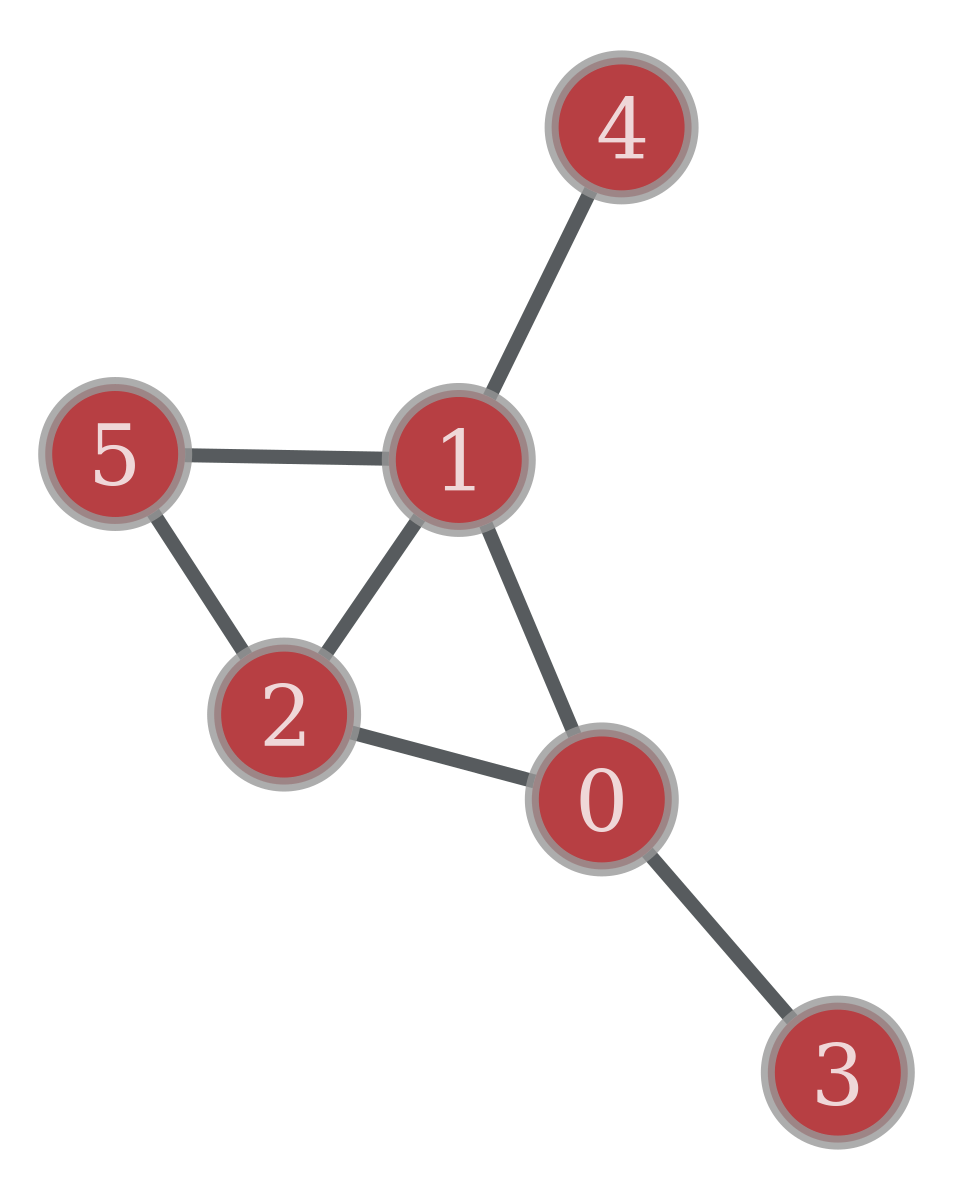

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3d7dc9fc10, at 0x7f3d66af0050>

In [89]:
rand_graph = naive_erd_ren(6, 0.6)
gt.graph_draw(rand_graph, vertex_text=rand_graph.vertex_index)

In [90]:
# source: http://vlado.fmf.uni-lj.si/pub/networks/doc/ms/rndgen.pdfhttp://vlado.fmf.uni-lj.si/pub/networks/doc/ms/rndgen.pdf
def fast_erd_ren(n, p):

    erd_ren = gt.Graph(directed=False)
    erd_ren.add_vertex(n)

    i = 1
    w = -1
    while i < n:
        r = np.random.rand()
        w = w+1+int(np.log(1-r)/np.log(1-p)) if p < 1 else w+1
        while w >= i and i < n:
            w = w-i
            i = i+1
        if (i < n):
            erd_ren.add_edge(i, w)

    return erd_ren

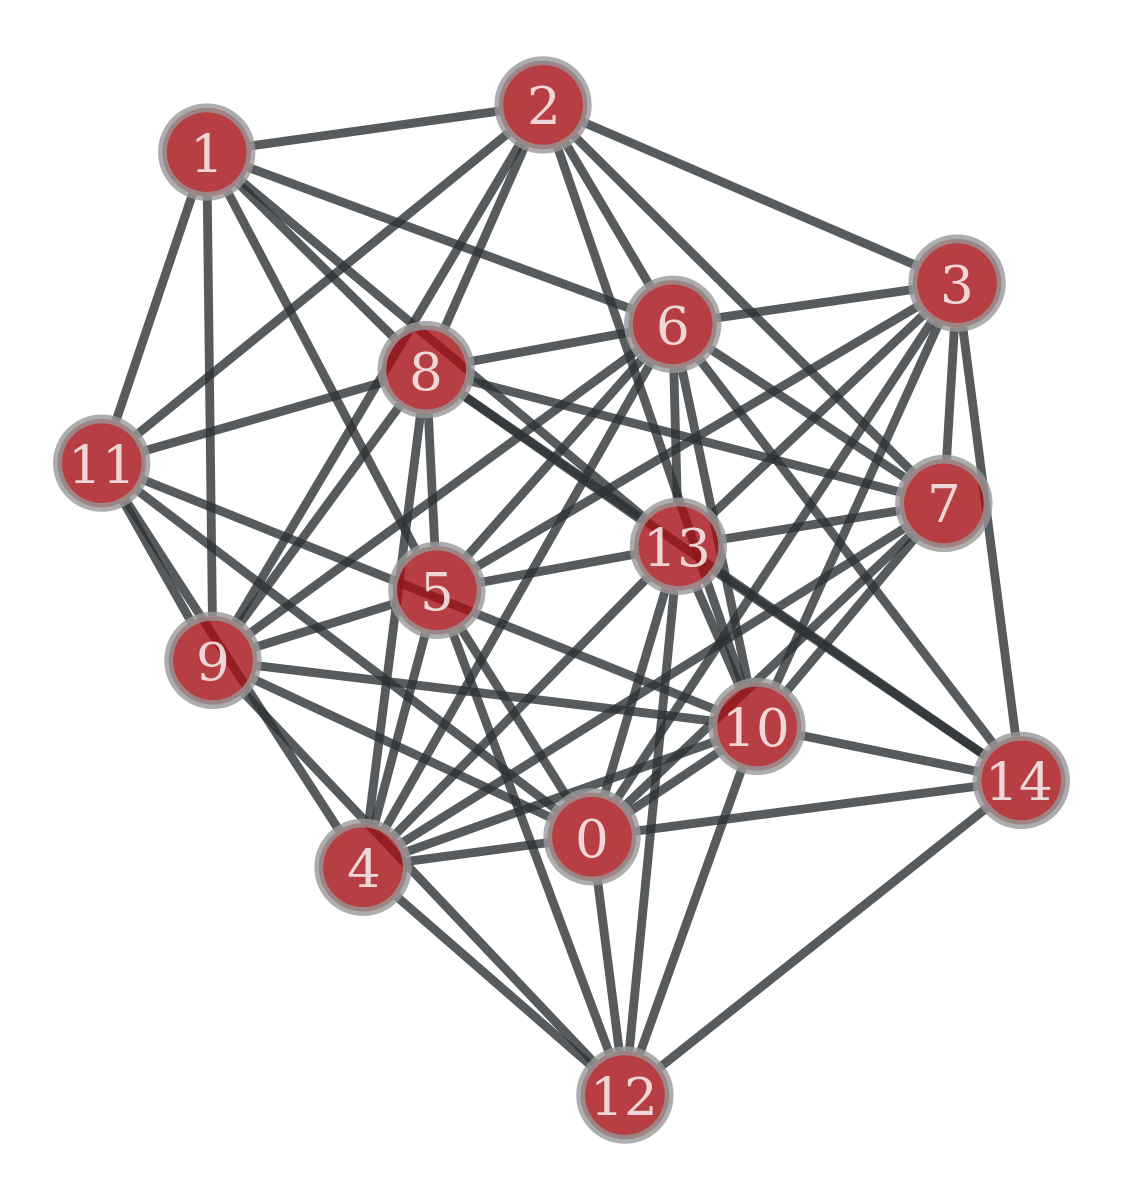

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3d7dc8db10, at 0x7f3d7dc8dc50>

In [91]:
fast_erd = naive_erd_ren(15, 0.6)
gt.graph_draw(fast_erd, vertex_text=fast_erd.vertex_index)

In [92]:
def chung_lu(exp_degree_seq):

    two_m = exp_degree_seq.sum()
    assert two_m % 2 == 0, 'Expected degree sequence must sum to an even number'

    cl_g = gt.Graph(directed=False)
    cl_g.add_vertex(len(exp_degree_seq))

    for i in cl_g.get_vertices():
        for j in cl_g.get_vertices():
            if i < j:
                p = exp_degree_seq[i] * exp_degree_seq[j] / two_m
                if np.random.rand() < p:
                    cl_g.add_edge(i, j)
            elif i == j:
                p = exp_degree_seq[i] * exp_degree_seq[i] / (2 * two_m)
                if np.random.rand() < p:
                    cl_g.add_edge(i, j)

    return cl_g

In [93]:
mean_deg_seq = np.random.randint(low=1, high= 6, size=(10,))

In [94]:
mean_deg_seq

array([2, 4, 1, 2, 2, 4, 4, 3, 3, 3])

In [95]:
def fast_chung_lu(exp_deg_seq):

    e_two_m = exp_deg_seq.sum()
    assert e_two_m % 2 == 0, 'Expected degree sequence must sum to an even number'

    cl_g = gt.Graph(directed=False)
    n_nodes = len(exp_deg_seq)
    cl_g.add_vertex(n_nodes)

    num_edges = np.random.poisson(e_two_m/2)
    print('number of edges', num_edges)
    e_stubs = np.repeat(np.arange(n_nodes), exp_deg_seq)

    for i in range(num_edges):
        u, v = np.random.choice(e_stubs, 2, replace=False)
        cl_g.add_edge(u, v)

    return cl_g

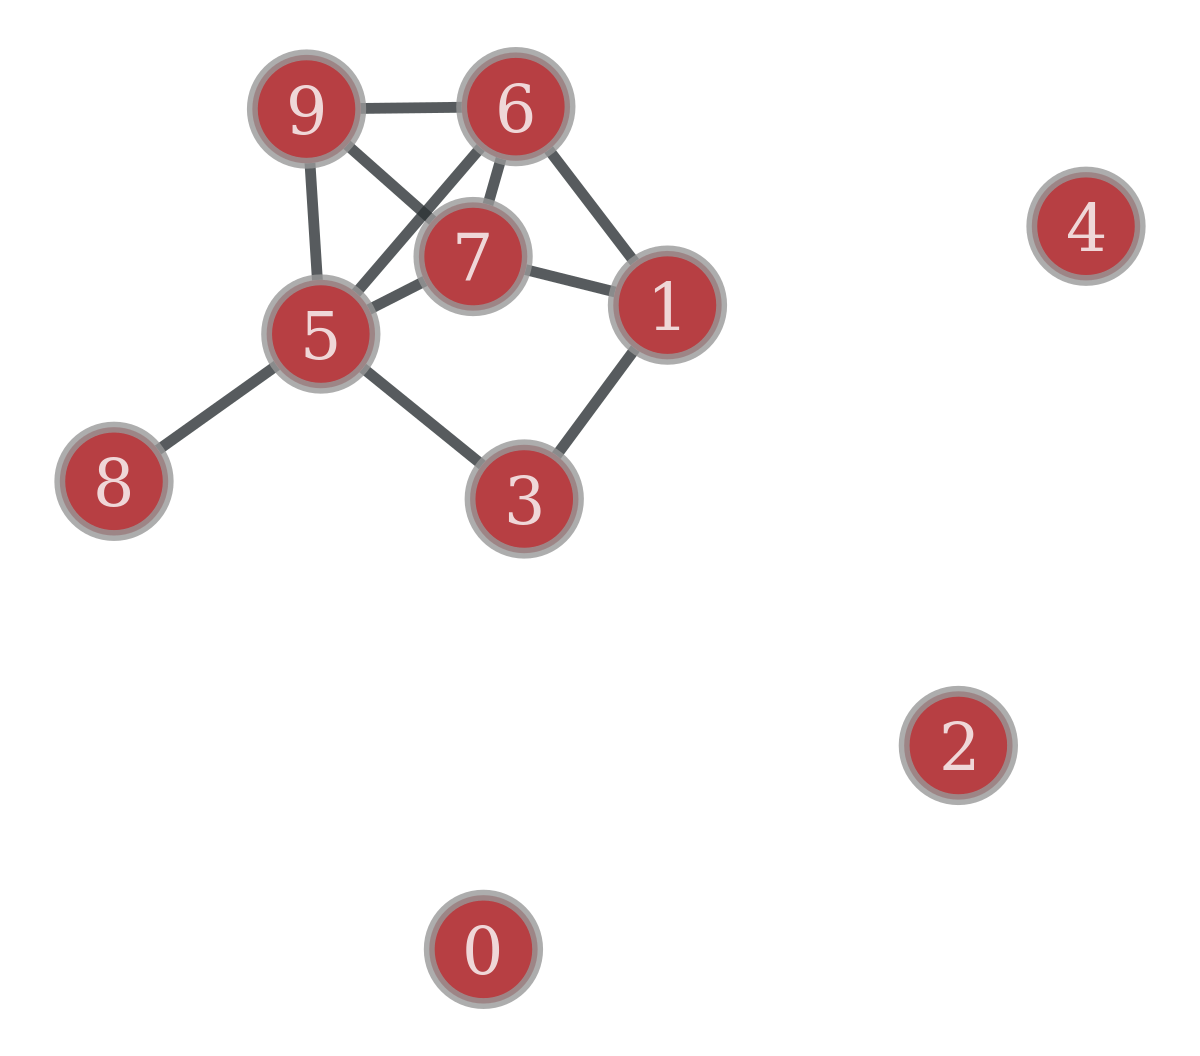

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3d7dc9fa90, at 0x7f3d66af0f90>

In [96]:
cl_graph = chung_lu(mean_deg_seq)
gt.graph_draw(cl_graph, vertex_text=cl_graph.vertex_index)

number of edges 46


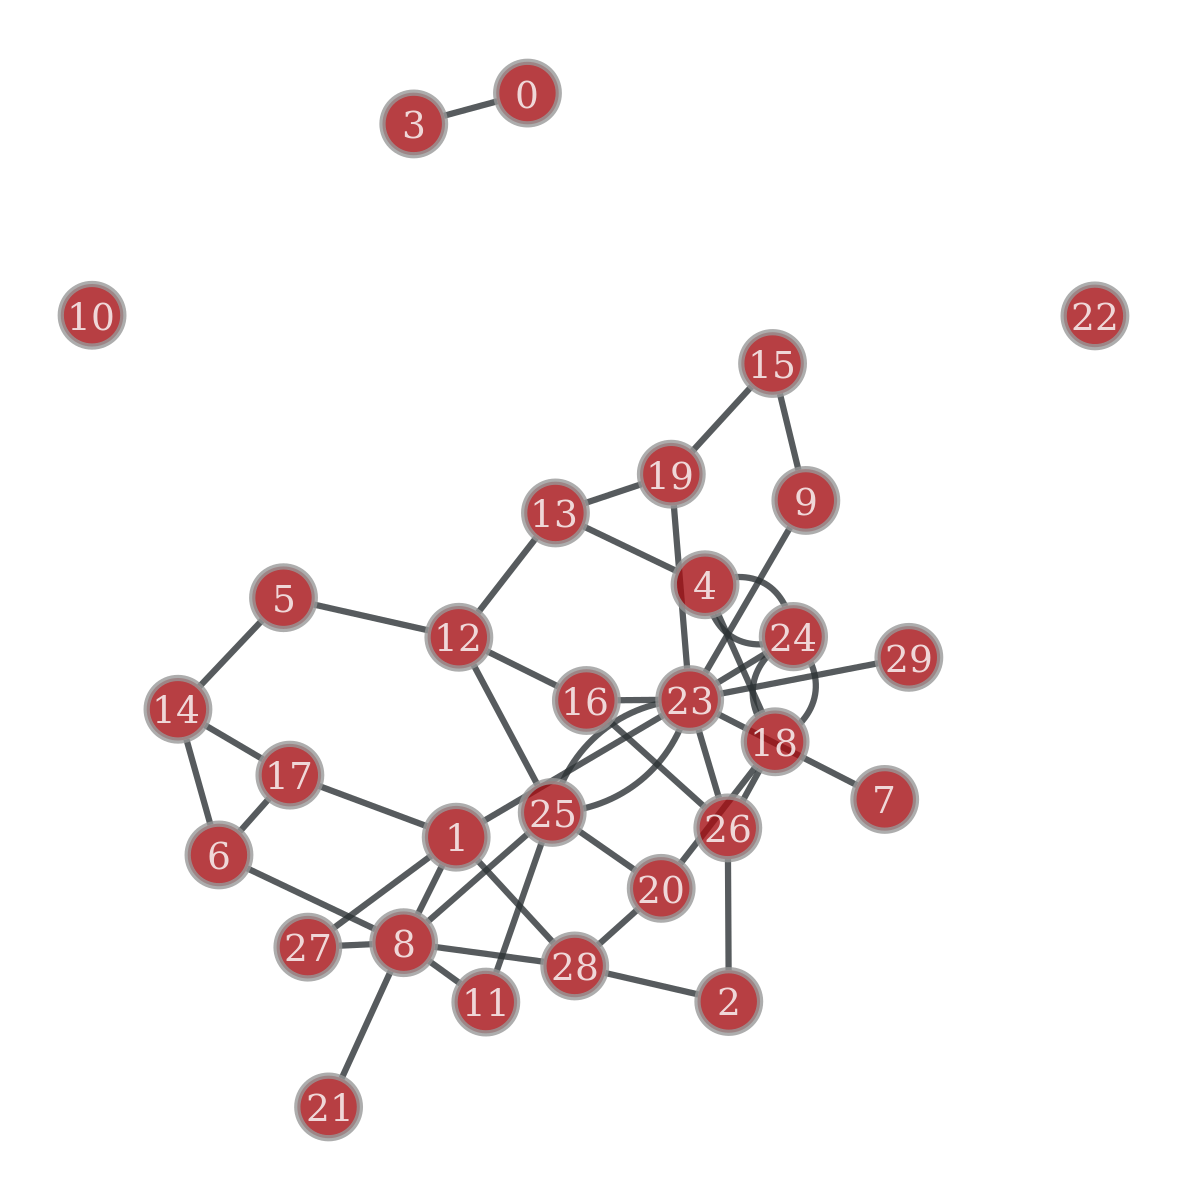

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3d7dcbccd0, at 0x7f3d7dcace50>

In [98]:
fast_clg = fast_chung_lu(np.random.randint(low=3, high=5, size=(30,)))
gt.graph_draw(fast_clg, vertex_text=fast_clg.vertex_index)